# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 4: Credit Portfolio Single Factor Model

In [2]:
# Importing the libraries
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.stats import norm
from utilities.ex1_utilities import (
    business_date_offset,
    get_discount_factor_by_zero_rates_linear_interp,
    bootstrap,
)

In [3]:
# Bootstrap

filename = "MktData_CurveBootstrap.xls"
dates, rates , discount_factors  = bootstrap(filename,0)

today = dates[0]

In [4]:
# Parameters
issuers_num = 100  # Number of bonds in the portfolio
maturity = 2  # Maturity in years

rating = "IG"  # Credit rating

expiry = business_date_offset(today, year_offset=maturity)

transition_matrix = pd.DataFrame(
    [[0.73, 0.25, 0.02], [0.35, 0.6, 0.05], [0, 0, 1]],
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"],
)

transition_matrix_2y =  transition_matrix @ transition_matrix

recovery_rate = 0.4
face_value = 1_000_000
rho = 0.15
mc_simulations = 1_000_000
alpha = 99 #confidence level of the test

In [5]:
        # Q1-Q3: Portfolio MtM Evaluate the present value in a year's time under various scenarios


df_expiry = get_discount_factor_by_zero_rates_linear_interp(
    today, expiry, dates, discount_factors
)

mid_date=business_date_offset(today, month_offset=6)
df_mid_date=get_discount_factor_by_zero_rates_linear_interp(
    today, mid_date, dates, discount_factors
)


one_year = business_date_offset(today, year_offset=1)
df_expiry_1y = get_discount_factor_by_zero_rates_linear_interp(
    today, one_year, dates, discount_factors
)


df_expiry_1y_2y = get_discount_factor_by_zero_rates_linear_interp(
    one_year, expiry, dates, discount_factors
)

one_year_mid_date=business_date_offset(today,  month_offset=18)
df_expiry_1y_mid_date=get_discount_factor_by_zero_rates_linear_interp(
    today, one_year_mid_date, dates, discount_factors
)

# Default probabilities
df_1y_def = transition_matrix.at[rating, 'Def']
df_2y_def = transition_matrix_2y.at[rating, 'Def']

# Print default probabilities
print(
    f"One year real world default probability: {df_1y_def:.2%}"
)
print(
    f"Two year real world default probability: {df_2y_def:.2%}"
)

# Survival probabilities
survival_prob_1y = 1 - df_1y_def
survival_prob_2y = 1 - df_2y_def

# Forward prices for IG and HY

fwd_price_ig = (1-df_1y_def) * (df_expiry/df_expiry_1y) + df_1y_def * (df_expiry_1y_mid_date/df_expiry_1y) * recovery_rate
fwd_price_hy = (1 - transition_matrix.at['HY', 'Def']) * (df_expiry/df_expiry_1y) + transition_matrix.at['HY', 'Def'] * (df_expiry_1y_mid_date/df_expiry_1y) * recovery_rate


# Print forward prices
print(
    f"Forward zero coupon bond IG: {fwd_price_ig:.4f}"
)
print(
    f"Forward zero coupon bond HY: {fwd_price_hy:.4f}"
)

# Portfolio Mark-to-Market (MtM)
bond_mtm = (
    transition_matrix.at[rating, rating] * df_expiry_1y * fwd_price_ig +
    transition_matrix.at[rating, 'HY'] * df_expiry_1y * fwd_price_hy +
    df_1y_def * recovery_rate * df_mid_date
)

bond_mtm = bond_mtm * face_value
ptf_mtm = issuers_num * bond_mtm

# Print portfolio MtM
print(f"Portfolio MtM: €{ptf_mtm:,.2f}")

One year real world default probability: 2.00%
Two year real world default probability: 4.71%
Forward zero coupon bond IG: 0.9581
Forward zero coupon bond HY: 0.9408
Portfolio MtM: €91,288,211.35


In [6]:
# Q4: Monte Carlo simulation
# Barriers and PnL for a single IG issuer
barrier_default = norm.ppf(transition_matrix.at['IG', 'Def'])
barrier_downgrade = norm.ppf(transition_matrix.at['IG', 'HY'] + transition_matrix.at['IG', 'Def'])
barrier_upgrade = np.inf  # It can't be upgraded

bond_mtm_actualized = bond_mtm / df_expiry_1y

loss_given_default = -(face_value * recovery_rate - bond_mtm_actualized)
loss_given_downgrade = -(face_value * fwd_price_hy - bond_mtm_actualized)
loss_status_quo = -(face_value * fwd_price_ig - bond_mtm_actualized)
loss_upgrade = 0

In [7]:
y = np.random.normal(size=(mc_simulations, 1))
z = np.random.normal(size=(mc_simulations, issuers_num))
# Adding correlation
v = rho * y + np.sqrt(1 - rho**2) * z

In [8]:
#Binary variables
#Parameters
defaults = np.zeros(mc_simulations)
downgrades = np.zeros(mc_simulations)
status_quo = np.zeros(mc_simulations)

upgrades = 0 # we don't have a higher rank than IG

for i in range(mc_simulations):
    for j in range(issuers_num): #we count the situation of any j-th issuer in the i-th simulation
        if v[i][j] < barrier_default:
            defaults[i] = defaults[i] + 1
        elif v[i][j] > barrier_downgrade:
            status_quo[i] = status_quo[i] + 1
        else:
            downgrades[i] = downgrades[i] + 1


print(f"Average defaults: {defaults.mean()}")
print(f"Average downgrades: {downgrades.mean()}")

Average defaults: 1.998798
Average downgrades: 25.000187


In [9]:
# Marginal distributions (check)
prob_default = defaults.mean() / issuers_num
prob_downgrade = downgrades.mean() / issuers_num
prob_status_quo = status_quo.mean() / issuers_num
prob_upgrades = upgrades / issuers_num

In [10]:
# Evaluating the one-year 99% VaR by taking into account defaults only/defaults and downgrades

# Here one should consider also the impact of the status quo
scenario1 = loss_given_default * defaults + loss_status_quo * (issuers_num - defaults)
scenario2 = loss_given_default * defaults + loss_given_downgrade * downgrades + loss_status_quo * status_quo

VaR1 = np.percentile(scenario1, alpha)
VaR2 = np.percentile(scenario2, alpha)

print(f"VaR only defaults: {VaR1:,.2f}€")
print(f"VaR defaults and downgrades: {VaR2:,.2f}€")

VaR only defaults: 2,372,735.34€
VaR defaults and downgrades: 2,822,104.38€


Text(0.5, 1.0, 'Loss distribution ')

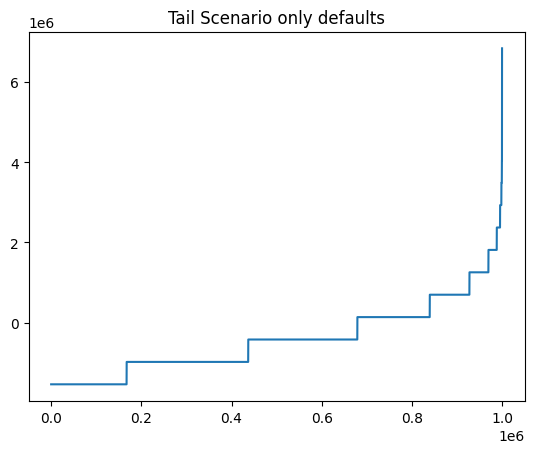

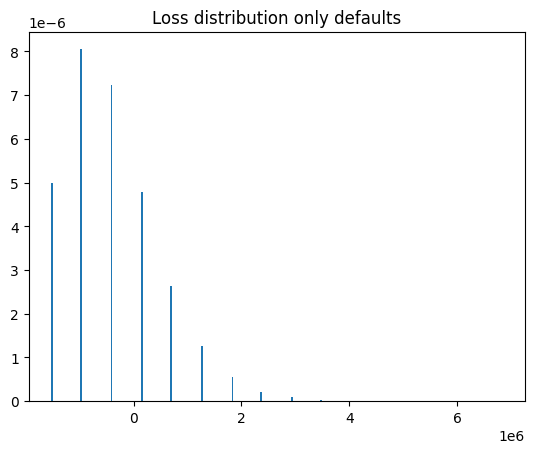

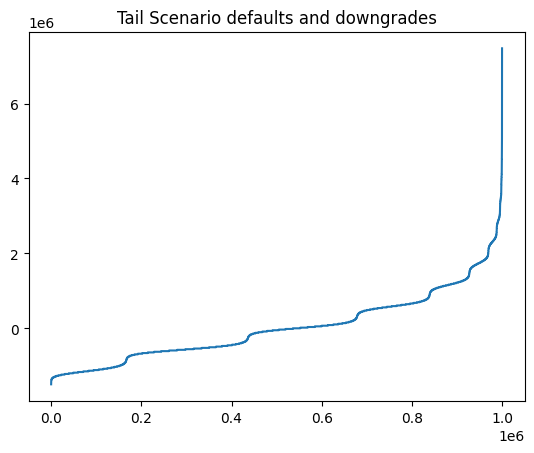

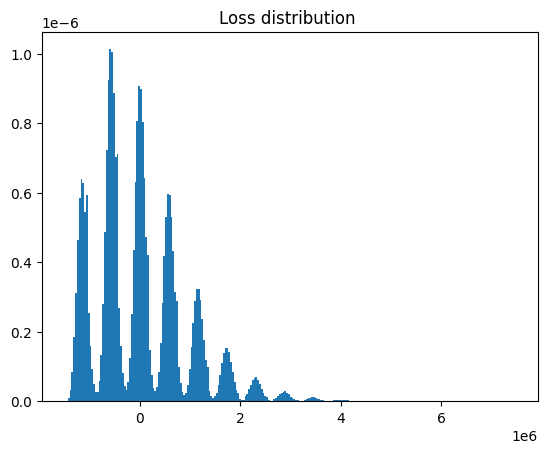

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sorted(scenario1))
plt.title("Tail Scenario only defaults")

plt.figure()
plt.hist(scenario1, bins=250, density=True)
plt.title("Loss distribution only defaults")

plt.figure()
plt.plot(sorted(scenario2))
plt.title("Tail Scenario defaults and downgrades")

plt.figure()
plt.hist(scenario2, bins=250, density=True)
plt.title("Loss distribution ")

In [12]:
# Q5: Monte Carlo simulation with changing correlation

# Defining a flag
use_high_rho = True  # Set to False for rho = 0%, True for rho = 30%

# Setting rho based on the flag
rho = 0.3 if use_high_rho else 0

# Generating random variables
y = np.random.normal(size=(mc_simulations, 1))
z = np.random.normal(size=(mc_simulations, issuers_num))

# adding correlation
v = rho * y + np.sqrt(1 - rho**2) * z

In [13]:
#Binary variables
defaults = np.zeros(mc_simulations)
downgrades = np.zeros(mc_simulations)
status_quo = np.zeros(mc_simulations)

upgrades = 0

for i in range(mc_simulations):
    for j in range(issuers_num):
        if v[i][j] < barrier_default:
            defaults[i] = defaults[i] + 1
        elif v[i][j] > barrier_downgrade:
            status_quo[i] = status_quo[i] + 1
        else:
            downgrades[i] = downgrades[i] + 1


print(f"Average defaults: {defaults.mean()}")
print(f"Average downgrades: {downgrades.mean()}")

Average defaults: 1.997985
Average downgrades: 24.992106


In [14]:
scenario = loss_given_default * defaults + loss_given_downgrade * downgrades + loss_status_quo * status_quo
VaR = np.percentile(scenario, alpha)

print(f"VaR defaults and downgrades: {VaR:,.2f}€")

VaR defaults and downgrades: 4,335,836.53€


In [27]:
# Q7:
# Parameters
recovery_rate2 = 0.1 #changed recovery rate
face_value = 1_000_000
rho = 0.15
mc_simulations = 1_000_000

In [28]:
# Forward prices for IG and HY

fwd_price_ig = (1-df_1y_def) * (df_expiry/df_expiry_1y) + df_1y_def * (df_expiry_1y_mid_date/df_expiry_1y) * recovery_rate2
fwd_price_hy = (1 - transition_matrix.at['HY', 'Def']) * (df_expiry/df_expiry_1y) + transition_matrix.at['HY', 'Def'] * (df_expiry_1y_mid_date/df_expiry_1y) * recovery_rate2


# Print forward prices
print(
    f"Forward zero coupon bond IG: {fwd_price_ig:.4f}"
)
print(
    f"Forward zero coupon bond HY: {fwd_price_hy:.4f}"
)

# Portfolio Mark-to-Market (MtM)
bond_mtm = (
    transition_matrix.at[rating, rating] * df_expiry_1y * fwd_price_ig +
    transition_matrix.at[rating, 'HY'] * df_expiry_1y * fwd_price_hy +
    df_1y_def * recovery_rate2 * df_mid_date
)

bond_mtm = bond_mtm * face_value
ptf_mtm = issuers_num * bond_mtm

# Print portfolio MtM
print(f"Portfolio MtM: €{ptf_mtm:,.2f}")

Forward zero coupon bond IG: 0.9522
Forward zero coupon bond HY: 0.9261
Portfolio MtM: €89,922,388.95


In [29]:
bond_mtm_actualized = bond_mtm / df_expiry_1y
loss_given_default = -(face_value * recovery_rate2 - bond_mtm_actualized)
loss_given_downgrade = -(face_value * fwd_price_hy - bond_mtm_actualized)
loss_status_quo = -(face_value * fwd_price_ig - bond_mtm_actualized)
loss_upgrade = 0

In [30]:
y = np.random.normal(size=(mc_simulations, 1))
z = np.random.normal(size=(mc_simulations, issuers_num))
# Adding correlation
v = rho * y + np.sqrt(1 - rho**2) * z

In [31]:
#Binary variables
defaults = np.zeros(mc_simulations)
downgrades = np.zeros(mc_simulations)
status_quo = np.zeros(mc_simulations)

upgrades = 0

for i in range(mc_simulations):
    for j in range(issuers_num):
        if v[i][j] < barrier_default:
            defaults[i] = defaults[i] + 1
        elif v[i][j] > barrier_downgrade:
            status_quo[i] = status_quo[i] + 1
        else:
            downgrades[i] = downgrades[i] + 1


print(f"Average defaults: {defaults.mean()}")
print(f"Average downgrades: {downgrades.mean()}")

Average defaults: 1.998911
Average downgrades: 24.992638


In [32]:
# Marginal distributions (check)
prob_default = defaults.mean() / issuers_num
prob_downgrade = downgrades.mean() / issuers_num
prob_status_quo = status_quo.mean() / issuers_num
prob_upgrades = upgrades / issuers_num

In [33]:
# Evaluating the one-year 99% VaR by taking into account defaults only/defaults and downgrades
# with the new recovery rate

# Here one should consider also the  impact of the status quo
scenario1 = loss_given_default * defaults + loss_status_quo * (issuers_num - defaults)
scenario2 = loss_given_default * defaults + loss_given_downgrade * downgrades + loss_status_quo * status_quo

VaR1 = np.percentile(scenario1, alpha)
VaR2 = np.percentile(scenario2, alpha)
expected_loss = loss_given_default * defaults.mean() + loss_given_downgrade * downgrades.mean() + loss_status_quo * status_quo.mean()

print(f"Expected loss: {expected_loss:,.2f}€")
print(f"VaR only defaults: {VaR1:,.2f}€")
print(f"VaR defaults and downgrades: {VaR2:,.2f}€")


Expected loss: 2,451.40€
VaR only defaults: 3,611,154.03€
VaR defaults and downgrades: 4,290,729.24€
